In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input, ZeroPadding3D, Activation, AveragePooling3D, MaxPooling3D, GlobalMaxPooling2D, Add
from keras.models import Model
from keras.models import Sequential
from keras import models
from keras import layers
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.initializers import glorot_uniform

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hsiexplo/Indian_pines.mat
/kaggle/input/hsiexplo/PaviaU_gt.mat
/kaggle/input/hsiexplo/Salinas_gt.mat
/kaggle/input/hsiexplo/Salinas_corrected.mat
/kaggle/input/hsiexplo/PaviaU.mat
/kaggle/input/hsiexplo/Indian_pines_gt (1).mat
/kaggle/input/hsiexplo/Salinas.mat
/kaggle/input/hsiexplo/Indian_pines_corrected.mat


In [3]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/kaggle/input/hsiexplo')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt (1).mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca


In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:

def identity_block(x, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    x_shortcut = x
    
    # First component of main path
    x = Conv3D(filters = F1, kernel_size = (1, 1, 1), strides = (1,1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)
        # Second component of main path (≈3 lines)
    x = Conv3D(filters = F2, kernel_size = (f, f, f), strides = (1,1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path (≈2 lines)
    x = Conv3D(filters = F3, kernel_size = (1, 1,1), strides = (1,1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    
    return x

In [10]:
def convolutional_block(x, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    x_shortcut = x


    ##### MAIN PATH #####
    # First component of main path 
    x = Conv3D(F1, (1, 1, 1), strides = (s,s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # Second component of main path (≈3 lines)
    x = Conv3D(filters = F2, kernel_size = (f, f, f), strides = (1,1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)


    # Third component of main path (≈2 lines)
    x = Conv3D(filters = F3, kernel_size = (1, 1, 1), strides = (1,1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)


    ##### SHORTCUT PATH #### (≈2 lines)
    x_shortcut = Conv3D(filters = F3, kernel_size = (1, 1, 1), strides = (s,s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(x_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    
    return x

In [11]:
S= windowSize
L=15

In [12]:
def ResNet50(input_shape=(S,S,L,1), classes=16):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    x=X_input

    # Zero-Padding
    x = ZeroPadding3D((3, 3, 3))(X_input)
#     padWithZeros(x,margin=2)

    # Stage 1
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    # Stage 2
    x = convolutional_block(x, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    x = convolutional_block(x, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    x = convolutional_block(x, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    x = convolutional_block(x, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    ### END CODE HERE ###

    # output layer
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(x)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = x, name='ResNet50')

    return model

In [13]:
# data Loading
XX, y = loadData(dataset)
XX= ((XX-np.mean(XX))/np.std(XX))
# print(XX)
XX.shape, y.shape

((145, 145, 200), (145, 145))

In [14]:
K = XX.shape[2]
XX.shape[2]

200

In [15]:
K = 30 if dataset == 'IP' else 15
K=15
XX,pca = applyPCA(XX,numComponents=K)

XX.shape

(145, 145, 15)

In [16]:
XX, y = createImageCubes(XX, y, windowSize=windowSize)

XX.shape, y.shape

((10249, 25, 25, 15), (10249,))

In [17]:
# Training and testing patches spitining
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(XX, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 15), (7175, 25, 25, 15), (3074,), (7175,))

In [18]:
#train data reshape
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 15, 1)

In [19]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

In [20]:
#S = windowSize
S = windowSize
L = K
# output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
output_units=6

In [21]:
model=ResNet50()

In [22]:
model.summary()
#plot_model(model,to_file='model.png',show_layer_names='False',show_shapes='True')

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 15, 1 0                                            
__________________________________________________________________________________________________
zero_padding3d_1 (ZeroPadding3D (None, 31, 31, 21, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 13, 13, 8, 64 22016       zero_padding3d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 8, 64 32          conv1[0][0]                      
___________________________________________________________________________________________

In [23]:
model.trainable = False

In [24]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(S,S,L,1)))
model.add(layers.Dense(256, activation='relu', input_dim=(S*S*L*1)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9375)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2400256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 2,404,368
Trainable params: 2,404,368
Non-trainable params: 0
_________________________________________________________________


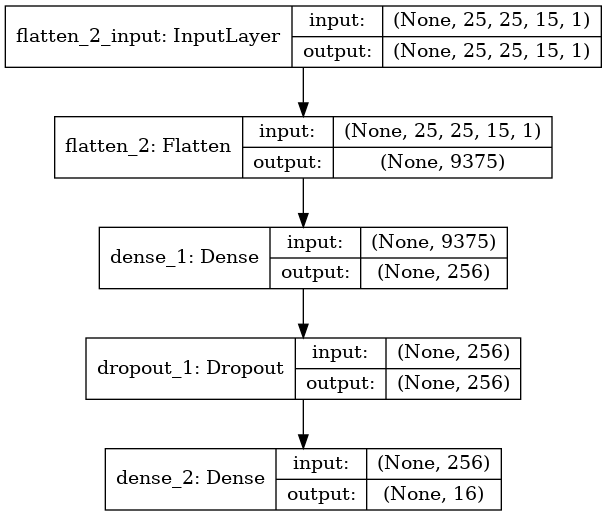

In [25]:
plot_model(model,to_file='model.png',show_layer_names='False',show_shapes='True')

In [26]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [27]:
# checkpoint
filepath = "/kaggle/working/best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [28]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=20, callbacks=callbacks_list)

Epoch 1/20
3074/3074 [==============================] - 1s 304us/step - loss: 1.8924 - accuracy: 0.5797

Epoch 00001: accuracy improved from -inf to 0.57970, saving model to /kaggle/working/best-model.hdf5
Epoch 2/20
3074/3074 [==============================] - 1s 172us/step - loss: 0.9290 - accuracy: 0.6721

Epoch 00002: accuracy improved from 0.57970 to 0.67209, saving model to /kaggle/working/best-model.hdf5
Epoch 3/20
3074/3074 [==============================] - 1s 173us/step - loss: 0.5357 - accuracy: 0.7902

Epoch 00003: accuracy improved from 0.67209 to 0.79018, saving model to /kaggle/working/best-model.hdf5
Epoch 4/20
3074/3074 [==============================] - 1s 177us/step - loss: 0.2864 - accuracy: 0.9128

Epoch 00004: accuracy improved from 0.79018 to 0.91282, saving model to /kaggle/working/best-model.hdf5
Epoch 5/20
3074/3074 [==============================] - 1s 176us/step - loss: 0.1627 - accuracy: 0.9593

Epoch 00005: accuracy improved from 0.91282 to 0.95934, saving

Validation 

In [29]:
# load best weights
model.load_weights("/kaggle/working/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [30]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 15, 1)

In [31]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [32]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.96      0.96      0.96      1000
           2       0.98      0.95      0.97       581
           3       0.98      0.93      0.96       166
           4       1.00      0.97      0.98       338
           5       0.99      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      0.86      0.92        14
           9       0.99      0.99      0.99       680
          10       0.97      0.99      0.98      1719
          11       1.00      0.97      0.99       415
          12       0.99      0.99      0.99       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99        65

    accuracy                           0.98      7175
   macro avg       0.99   

In [33]:

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [34]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [35]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/kaggle/working/classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

7175/7175 [==============================] - 1s 135us/step


In [36]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [37]:
# load the original image
XX, y = loadData(dataset)

In [38]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [39]:
XX,pca = applyPCA(XX, numComponents=numComponents)

In [40]:
XX = padWithZeros(XX, PATCH_SIZE//2)

In [41]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(XX,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

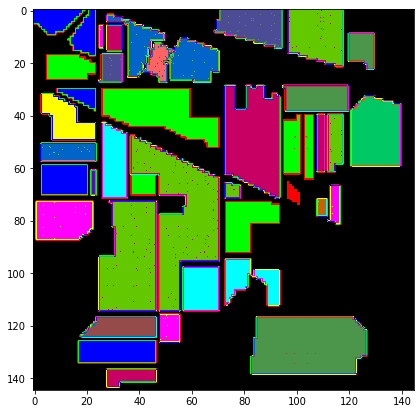

In [42]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

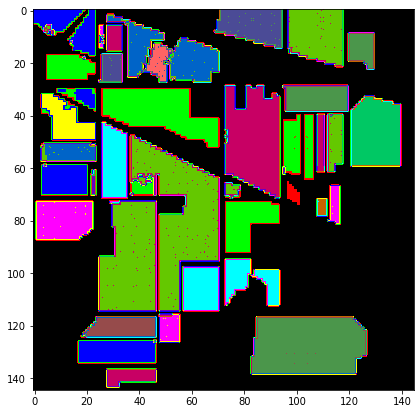

In [43]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [44]:
spectral.save_rgb("/kaggle/working/predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)